# A cloud of languages

A cloud of languages based on a letter-substitution distances between words (edit-distance, aka Levenshtein distance). Supposedly similar languages should be close to each other.

Most of data comes from this twitter account: https://twitter.com/EuroMinLang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding as LLE

In [2]:
# Edit-distance (dynamic programming)
def edit_distance(s1, s2):
    n1 = len(s1)
    n2 = len(s2)
    mem = [[0 for j in range(n2+1)] for i in range(n1+1)]
    # mem is Number of edits so far
    for i in range(n1+1):
        for j in range(n2+1):
            if   i==0: mem[i][j] = j
            elif j==0: mem[i][j] = i
            elif s1[i-1]==s2[j-1]: mem[i][j] = mem[i-1][j-1]
            else: mem[i][j] = 1 + min([mem[i-1][j-1], mem[i-1][j], mem[i][j-1]])
    return mem[n1][n2]

edit_distance('hlava12345dd', 'golova12345')

5

In [3]:
# Read the data
with open('parallel_vocabs.txt', 'r', encoding="utf8") as f:
    lines = f.readlines()

In [4]:
# Put data in boxes

prefixes = ['Mouse face', 'Pig face', 'Rabbit face', 'Cow face', 'Pig face', 'Frog face', 
            'Chicken', 'Wolf', 'Fox', 'Dog face', 'Cat face', 'Bear face', 'Bird', 
            'Horse face', 'Honeybee', 'Butterfly', 'Deer', 'Snake', 'Fish', 'Duck', 'Goat',
           'Chipmunk', 'Monkey', 'Boar', 'Otter', 'Beaver', 'Snail', 'Spider', 'Ant',
           'Swan', 'Fly', 'Owl', 'Hedgehog', 'Sheep']
box = {s : s.split(' ')[0].lower() for s in prefixes}
box['Chicken'] = 'hen'
box['Baby chick'] = 'chicken'
box['Lady beetle'] = 'ladybug'

row1 = 'а б в г д е ж з и к л м н о п р с т у ф х ц ч ш ў α β γ δ ε ζ ι κ λ μ ν ο π ρ σ τ υ φ ξ χ'.split(' ')
row2 = 'a b v g d e ž z i k l m n o p r s t u f h c č š ł a b g d e z i k l m n o p r s t u f x h'.split(' ')
translit = {row1[i] : row2[i] for i in range(len(row1))}

summary = {}    
bag = {}

lang = ''
head_flag = False
for s in lines:
    s = s.strip()  # Remove leading and trailing spaces
    if not s: continue # Skip empty lines
    if s[0]=='@':  # New language
        author = s
        head_flag = True # Expect new language
        continue
    if head_flag:
        if s[-5:]=='(big)': # For now isn't used, but may be useful for vizualization later
            big = True
            s = s[:-5].strip()
        else:
            big = False
        lang = s
        head_flag = False
        bag[lang] = bag.get(lang, {}) # In case the language is present more than once
        continue
    identified = False
    for key,value in box.items():        
        if s.find(key)==0:
            word = s[len(key):].lower()
            word = word.split(',')[0].split('/')[0].strip() # If more than one variant, pick the first one
            word = ''.join([translit[c] if c in translit else c for c in word ])
            bag[lang][value] = word
            summary[value] = summary.get(value, 0)+1
            identified = True
    if not identified:
        #print(s)
        pass
    
#print(bag)
print(summary)

{'dog': 43, 'cat': 43, 'mouse': 44, 'rabbit': 41, 'bear': 42, 'cow': 41, 'pig': 42, 'frog': 42, 'hen': 13, 'chicken': 12, 'bird': 41, 'wolf': 43, 'fox': 42, 'horse': 14, 'honeybee': 42, 'butterfly': 42, 'deer': 12, 'ladybug': 14, 'snake': 14, 'fish': 41, 'duck': 13, 'chipmunk': 12, 'goat': 13, 'monkey': 1, 'boar': 1, 'otter': 1, 'beaver': 1, 'snail': 1, 'ant': 3, 'spider': 3, 'fly': 2, 'sheep': 2, 'owl': 2, 'hedgehog': 2, 'swan': 1}


In [5]:
# Calculate distance matrix

lang_list = list(bag.keys())
nlangs = len(lang_list)
dist = np.zeros((nlangs,nlangs))

wordlist = ['dog', 'cat', 'rabbit', 'cow', 'pig', 'wolf', 'fox', 'mouse', 'bear', 'frog', 'bird', 
            'honeybee', 'butterfly', 'fish']

for l1 in range(nlangs):
    print(lang_list[l1], end=' ')
    for l2 in range(l1):
        lang1 = lang_list[l1]
        lang2 = lang_list[l2]
        x = 0
        n = 0        
        for word in wordlist:
            if word in bag[lang2].keys() and word in bag[lang1].keys():
                x += edit_distance(bag[lang1][word], bag[lang2][word])
                n += 1
        dist[l1,l2] = x/n
        
# Post-processing
dist = dist + dist.T # Make symmetric
#dist

Sulrsilvan Lengadocian Aghul Sölring Lemosin Nissart Catalan Fenouillèdes Manx Sardinian Kernewek Gallo Breton French Vallader Saintongeais Uncroatian Meadow Mari Gardenese Lohären Sicilian Walloon Lombard Neapolitan Piedmontese Vivaro Genoese Welsh Irish Arpitan West Frisian Scots Asturian Corsican Cornish Falemos Aragonese Galician Alsatian Luxembourgish Basque Russian English 

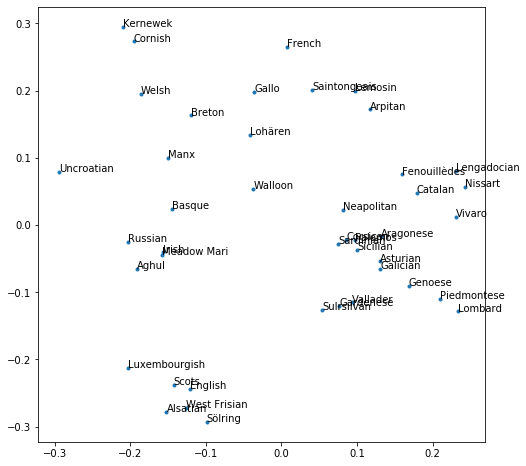

In [6]:
# Projection

emb = LLE(n_components=2, n_neighbors=len(lang_list)-1)
y = emb.fit_transform(dist)

plt.figure(figsize=(8,8));
plt.plot(y[:,0], y[:,1], '.');
for i in range(len(lang_list)):
    plt.text(y[i,0], y[i,1], lang_list[i])

Template

```
Dog face 
Cat face 
Mouse face 
Rabbit face 
Bear face 
Cow face 
Pig face 
Frog face 
Wolf face 
Fox face 
Bird 
Fish 
Butterfly 
Honeybee 
```